In [1]:
# meta-data
figure_num_and_caption = "fig_01_HadISST_global_and_annual_mean_SST_anomalies_all_variants"

# Import packages

In [2]:
%matplotlib inline
import itertools
import functools
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Make plots nice

In [4]:
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("inferno", n_colors=12)
plt.rcParams["figure.figsize"] = [15, 10]

# Open the data files and extract data

In [5]:
# path to the data file
data_file = Path("input_data/HadISST_sst.nc")

# open data set and extract SST (mask for sst=-1000)
ds = xr.open_dataset(data_file, chunks={"time": 12, "latitude": 90, "longitude": 120})
sst = ds.sst.sel(time=slice("1900-01-01", "2011-01-01"))
sst = sst.where(sst != -1000.0)
sst

<xarray.DataArray 'sst' (time: 1332, latitude: 180, longitude: 360)>
dask.array<shape=(1332, 180, 360), dtype=float32, chunksize=(12, 90, 120)>
Coordinates:
  * time       (time) datetime64[ns] 1900-01-16T12:00:00 1900-02-15 ...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 85.5 84.5 83.5 82.5 ...
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

# Function definitions

In [6]:
def wgt_glob_mean(data):
    cosine_latitude = np.cos(np.pi / 180.0 * data.coords["latitude"])
    data = ((cosine_latitude * data).sum(dim=["latitude", "longitude"])
            / (cosine_latitude + 0 * data).sum(dim=["latitude", "longitude"]))
    return data

In [7]:
def arit_glob_mean(data):
    data = data.mean(dim=["latitude", "longitude"])
    return data

In [8]:
def ann_mean(data):
    data = data.resample(time="12M").mean(dim="time")
    return data

In [9]:
def tmp_anom(data):
    data = data - data.mean("time")
    return data

In [10]:
# all permutations
permuted_funcs = itertools.chain(
    itertools.permutations([wgt_glob_mean, ann_mean, tmp_anom]),
    itertools.permutations([arit_glob_mean, ann_mean, tmp_anom]))
    

# create and save data set
_ana = []
for funs in permuted_funcs:
    _name = "-OF-".join(fn.__name__ for fn in funs)
    _ana.append(functools.reduce(lambda x, f: f(x), funs, sst).compute().rename(_name))
means_ds = xr.merge(_ana)
means_ds.to_netcdf("output_data/{}.nc".format(figure_num_and_caption))

In [11]:
means_ds

<xarray.Dataset>
Dimensions:                                 (time: 112)
Coordinates:
  * time                                    (time) datetime64[ns] 1900-01-31 ...
Data variables:
    wgt_glob_mean-OF-ann_mean-OF-tmp_anom   (time) float32 -0.18389893 ...
    wgt_glob_mean-OF-tmp_anom-OF-ann_mean   (time) float32 -0.18503761 ...
    ann_mean-OF-wgt_glob_mean-OF-tmp_anom   (time) float32 -0.05233383 ...
    ann_mean-OF-tmp_anom-OF-wgt_glob_mean   (time) float32 -0.10681296 ...
    tmp_anom-OF-wgt_glob_mean-OF-ann_mean   (time) float32 -0.107167885 ...
    tmp_anom-OF-ann_mean-OF-wgt_glob_mean   (time) float32 -0.10716787 ...
    arit_glob_mean-OF-ann_mean-OF-tmp_anom  (time) float32 -0.2965393 ...
    arit_glob_mean-OF-tmp_anom-OF-ann_mean  (time) float32 -0.29864025 ...
    ann_mean-OF-arit_glob_mean-OF-tmp_anom  (time) float32 0.25260925 ...
    ann_mean-OF-tmp_anom-OF-arit_glob_mean  (time) float32 -0.112385795 ...
    tmp_anom-OF-arit_glob_mean-OF-ann_mean  (time) float32 -0.11259

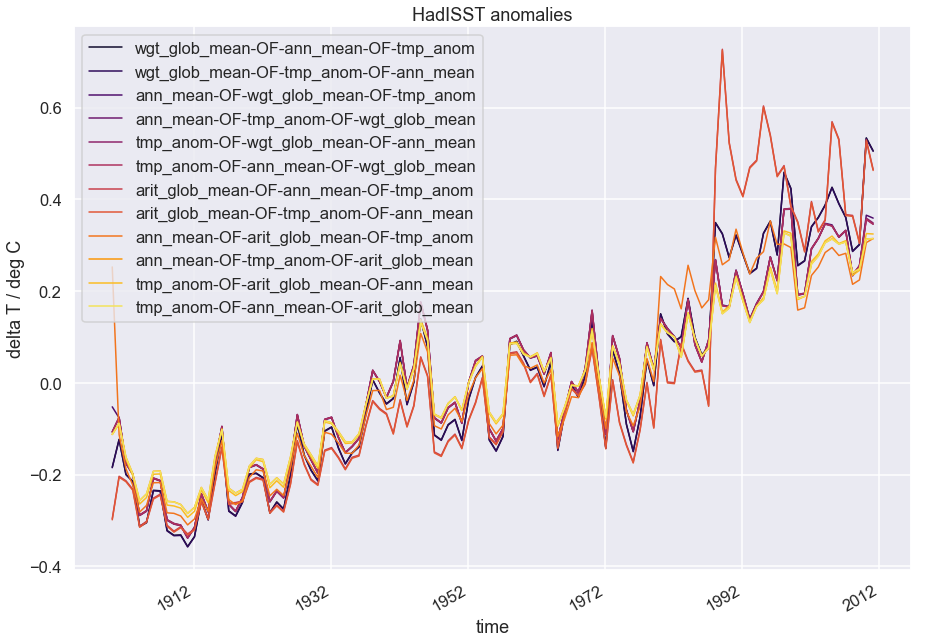

In [12]:
fig, ax = plt.subplots(1, 1)

for k, v in means_ds.data_vars.items():
    v.plot(ax=ax, linewidth=1.5)

ax.set_title("HadISST anomalies")
ax.set_ylabel("delta T / deg C")

yax_min = np.min(np.array([v.min() for k, v in means_ds.data_vars.items()])) - 0.05
yax_max = np.max(np.array([v.max() for k, v in means_ds.data_vars.items()])) + 0.05
ax.set_ylim((yax_min, yax_max))

ax.legend(loc=0);

plt.savefig("images/{}.png".format(figure_num_and_caption));

# Software that was used

In [13]:
!(conda list)

# packages in environment at /home/wrath/miniconda3_20171008/envs/repro_examples:
#
asciitree                 0.3.3                      py_2    conda-forge
backcall                  0.1.0                      py_0    conda-forge
blas                      1.0                         mkl  
bleach                    2.1.4                      py_1    conda-forge
bokeh                     0.13.0                   py36_0  
bzip2                     1.0.6                h14c3975_5  
ca-certificates           2018.03.07                    0  
certifi                   2018.8.24                py36_1  
cftime                    1.0.0b1          py36h035aef0_0  
click                     6.7                      py36_0  
cloudpickle               0.5.5                    py36_0  
curl                      7.61.0               h84994c4_0  
cycler                    0.10.0                   py36_0  
cytoolz                   0.9.0.1          py36h14c3975_1  
dask                      0.19.1     